# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

## Import библиотек

In [ ]:
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

[Документация по CatBoost](https://catboost.ai/en/docs/)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
plt.style.use('dark_background')

Функция чтобы посчитал кросс-валидацию

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_poly = pd.DataFrame(scores)
    display(DF_poly)
    print('\n')
    print(DF_poly.mean()[2:])

Функция чтобы нарисовать значимость признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    # У CatBoost значимость признаков не нормированная
    feature_importance = model.feature_importances_/np.sum(model.feature_importances_)

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

## Считываем файл в DataFrame



метод `.read_csv(path,delimiter) `

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

Make         Model  Year      Style  Distance  \
0          Toyota         Prius  2011  Hatchback  195000.0   
1         Renault  Grand Scenic  2014  Universal  135000.0   
2         Renault        Laguna  2012  Universal  110000.0   
3            Opel         Astra  2006  Universal  200000.0   
4        Mercedes          Vito  2000   Microvan  300000.0   
...           ...           ...   ...        ...       ...   
32069  Volkswagen        Passat  2016      Sedan   88000.0   
32070  Land Rover    Freelander  2002  Crossover  225000.0   
32071       Dacia     Logan Mcv  2015  Universal   89000.0   
32072       Mazda             6  2006      Combi  370000.0   
32073     Renault  Grand Scenic  2006    Minivan  300000.0   

       Engine_capacity(cm3)     Fuel_type Transmission  Price(euro)  \
0                    1800.0        Hybrid    Automatic       7750.0   
1                    1500.0        Diesel       Manual       8550.0   
2                    1500.0        Diesel       Manual       6550.0   
3                    1600.0  Metan/Propan       Manual       4100.0   
4                    2200.0        Diesel       Manual       3490.0   
...                     ...           ...          ...          ...   
32069                1800.0        Petrol    Automatic      11500.0   
32070                1800.0  Metan/Propan       Manual       4400.0   
32071                1500.0        Diesel       Manual       7000.0   
32072                2000.0        Diesel       Manual       4000.0   
32073                1500.0        Diesel       Manual       4000.0   

            km_year  
0      17727.272727  
1      16875.000000  
2      11000.000000  
3      12500.000000  
4      13636.363636  
...             ...  
32069  14666.666667  
32070  11250.000000  
32071  12714.285714  
32072  23125.000000  
32073  18750.000000  

[32074 rows x 10 columns]

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

# Классификация

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

cv_clf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

## Подготовим данные

In [ ]:
X = DF.drop(columns = ["Transmission"])
y = DF["Transmission"]
features_names = list(DF.drop(columns = ["Transmission"]).columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


[Принято через Pool](https://catboost.ai/en/docs/concepts/python-reference_pool)

In [ ]:
from catboost import Pool

In [ ]:
train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features = cat_columns[:-1],
    feature_names=features_names
)

eval_data = Pool(
    data=X_test,
    label=y_test,
    cat_features = cat_columns[:-1],
    feature_names=features_names
)

## Моделька

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = CatBoostClassifier(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns[:-1],
                           depth = 3,
                           eval_metric= 'BalancedAccuracy'
                           )


In [ ]:
model.fit(X=train_data,
          eval_set=eval_data,
          )

Learning rate set to 0.068338
0:	learn: 0.8050979	test: 0.8161216	best: 0.8161216 (0)	total: 26.5ms	remaining: 26.5s
100:	learn: 0.8482177	test: 0.8527918	best: 0.8530389 (79)	total: 3.31s	remaining: 29.5s
200:	learn: 0.8557683	test: 0.8579357	best: 0.8580501 (199)	total: 6.03s	remaining: 24s
300:	learn: 0.8590746	test: 0.8589654	best: 0.8589654 (300)	total: 13.8s	remaining: 32s
400:	learn: 0.8612315	test: 0.8606797	best: 0.8606989 (396)	total: 20.9s	remaining: 31.3s
500:	learn: 0.8629501	test: 0.8611374	best: 0.8614037 (444)	total: 29.1s	remaining: 28.9s
600:	learn: 0.8646495	test: 0.8613095	best: 0.8620335 (559)	total: 35.3s	remaining: 23.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8620334637
bestIteration = 559

Shrink model to first 560 iterations.


In [ ]:
y_predict=model.predict(eval_data)

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

              precision    recall  f1-score   support

      Manual       0.88      0.81      0.85      4370
   Automatic       0.85      0.91      0.88      5253

    accuracy                           0.87      9623
   macro avg       0.87      0.86      0.86      9623
weighted avg       0.87      0.87      0.87      9623



**Значимые Параметры**

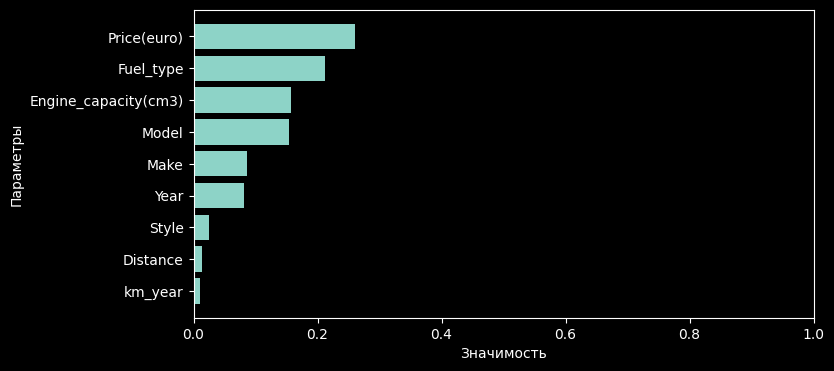

In [ ]:
feature_importance_plotter(model, np.array(features_names))

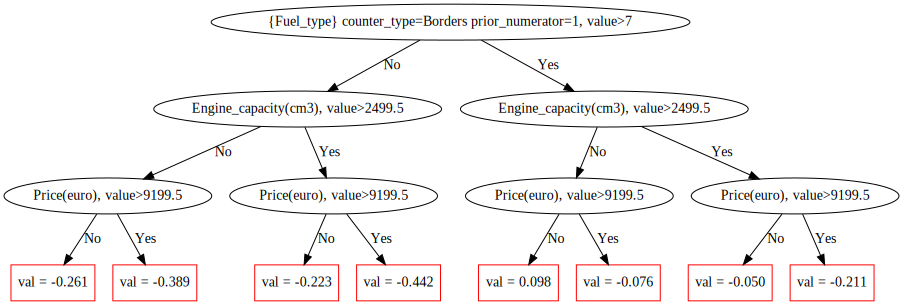

In [ ]:
#@title Глубина дерева для Отрисовки{ run: "auto" }
tree_idx=9 #@param {type:"slider", min:0, max:25, step:1}

model.plot_tree(tree_idx=tree_idx,
                pool = train_data)

**История обучения**

In [ ]:
results = model.evals_result_

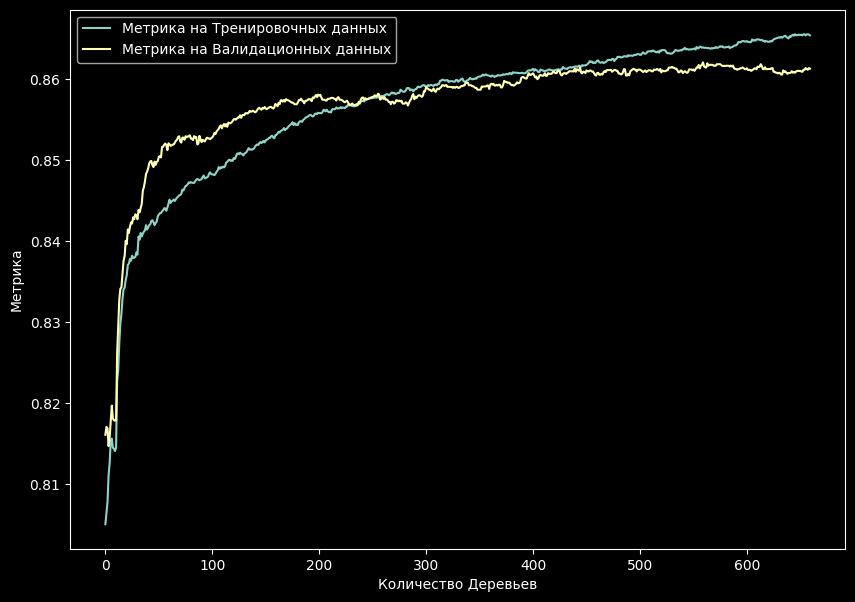

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results["learn"]["BalancedAccuracy"], label="Метрика на Тренировочных данных")
plt.plot(results["validation"]["BalancedAccuracy"], label="Метрика на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();

Можно проанализировать отдельные метрики

[Список поддерживаемых метрик](https://catboost.ai/en/docs/references/custom-metric__supported-metrics)

In [ ]:
metrics = model.eval_metrics(eval_data, metrics = ['AUC','Logloss','TotalF1']);

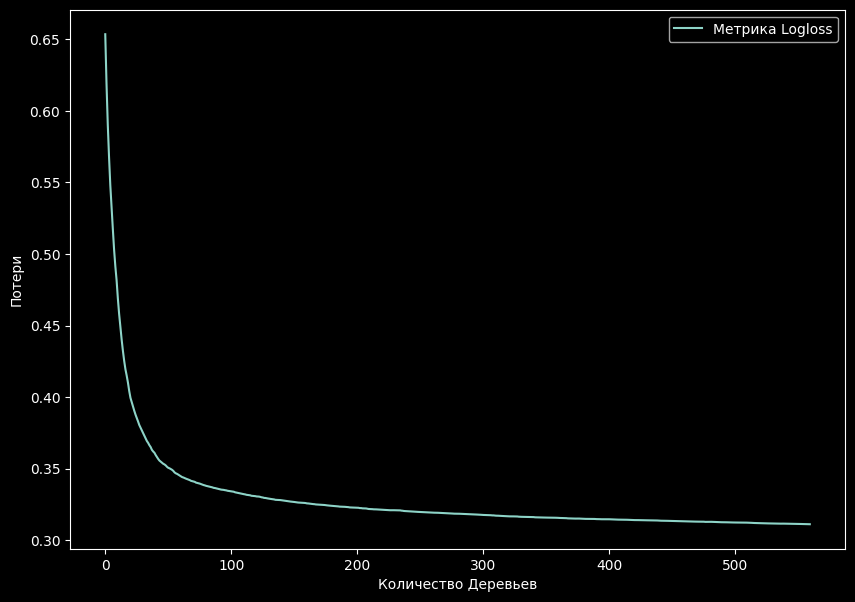

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(metrics["Logloss"], label="Метрика Logloss")
plt.xlabel("Количество Деревьев")
plt.ylabel("Потери")
plt.legend();

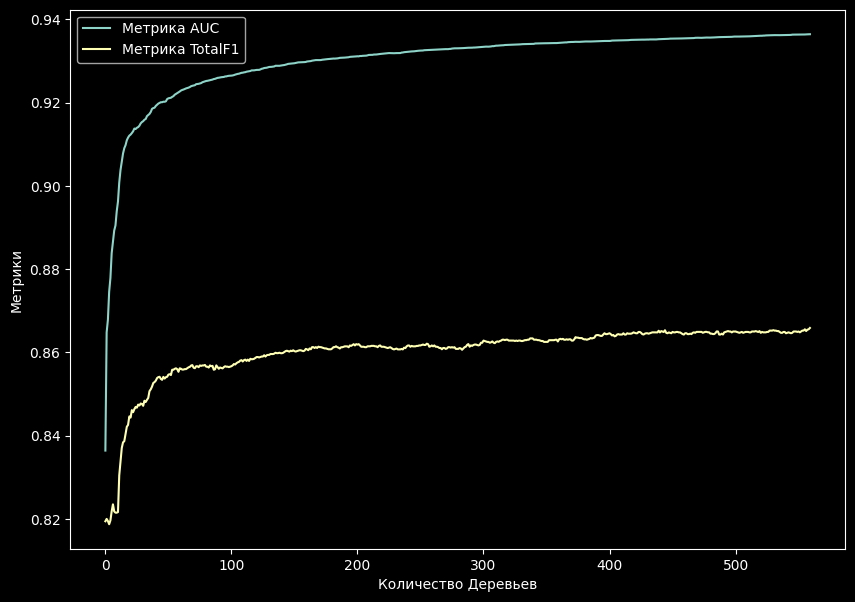

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(metrics["AUC"], label="Метрика AUC")
plt.plot(metrics["TotalF1"], label="Метрика TotalF1")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрики")
plt.legend();

Можно "скукожить модель"

In [ ]:
model.shrink(100)

y_predict=model.predict(eval_data)

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

              precision    recall  f1-score   support

      Manual       0.87      0.80      0.84      4370
   Automatic       0.85      0.90      0.87      5253

    accuracy                           0.86      9623
   macro avg       0.86      0.85      0.85      9623
weighted avg       0.86      0.86      0.86      9623



# Регрессия

In [ ]:
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

Функция которая пишет отчет по ошибкам регрессии (на минималках)

In [ ]:
def regression_report(y_test,y_predict):
    print('Ошибка на тестовых данных')
    print('MSE: %.1f' % mse(y_test,y_predict))
    print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))

    print('R2 : %.4f' %  r2_score(y_test,y_predict))

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

In [ ]:
cv_reg = ShuffleSplit(n_splits=5, random_state=42)

**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

In [ ]:
X_reg = DF.drop(columns = ["Price(euro)"])
y_reg = DF["Price(euro)"]
features_names_reg = list(DF.drop(columns = ["Price(euro)"]).columns)


X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

In [ ]:
train_data_reg = Pool(
    data=X_reg_train,
    label=y_reg_train,
    cat_features = cat_columns,
    feature_names=features_names_reg
)

eval_data_reg = Pool(
    data=X_reg_test,
    label=y_reg_test,
    cat_features = cat_columns,
    feature_names=features_names_reg
)

## Моделька

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model_reg = CatBoostRegressor(iterations = 1000,
                           early_stopping_rounds=100,
                           verbose = 100,
                           cat_features = cat_columns,
                           depth = 3,
                           eval_metric= 'MAE'
                           )


In [ ]:
model_reg.fit(X=train_data_reg,
          eval_set=eval_data_reg,
          )

Learning rate set to 0.082993
0:	learn: 5879.8131740	test: 6114.3686619	best: 6114.3686619 (0)	total: 111ms	remaining: 1m 50s
100:	learn: 2207.6103576	test: 2291.1604028	best: 2291.1604028 (100)	total: 4.99s	remaining: 44.4s
200:	learn: 2090.0252940	test: 2184.3715020	best: 2184.3713655 (199)	total: 8.58s	remaining: 34.1s
300:	learn: 2025.6217747	test: 2133.6224321	best: 2133.6224321 (300)	total: 11.6s	remaining: 27s
400:	learn: 1993.1352789	test: 2110.9084360	best: 2110.8587555 (399)	total: 15s	remaining: 22.4s
500:	learn: 1966.5084360	test: 2093.7771915	best: 2093.7771915 (500)	total: 19.4s	remaining: 19.3s
600:	learn: 1946.2035100	test: 2080.5963572	best: 2080.5486303 (599)	total: 22.7s	remaining: 15.1s
700:	learn: 1926.3131638	test: 2069.2431358	best: 2069.2431358 (700)	total: 26.2s	remaining: 11.2s
800:	learn: 1912.5445474	test: 2060.5053274	best: 2060.0628031 (794)	total: 30.2s	remaining: 7.5s
900:	learn: 1900.6326380	test: 2053.3558948	best: 2053.0864803 (895)	total: 35.2s	remai

In [ ]:
y_predict=model_reg.predict(eval_data_reg)

regression_report(y_reg_test,y_predict)

Ошибка на тестовых данных
MSE: 15682190.6
RMSE: 3960.1
R2 : 0.8395


**Значимые Параметры**

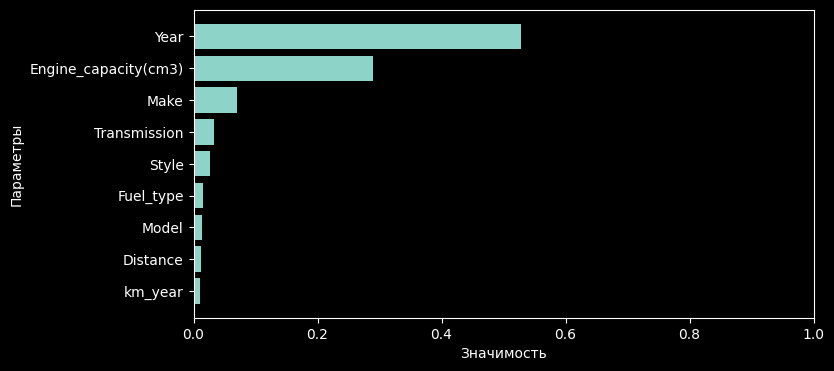

In [ ]:
feature_importance_plotter(model_reg, np.array(features_names_reg))

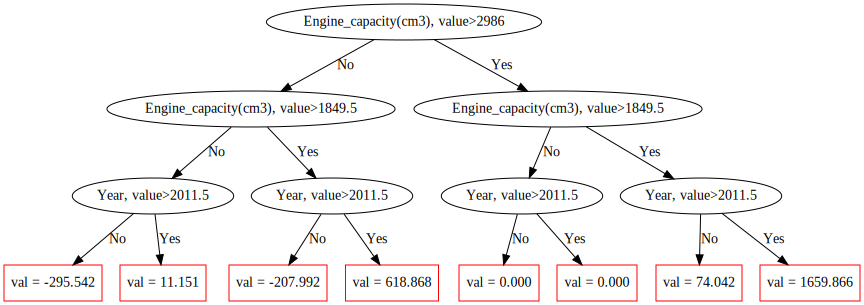

In [ ]:
#@title Глубина дерева для Отрисовки{ run: "auto" }
tree_idx=5 #@param {type:"slider", min:0, max:25, step:1}

model_reg.plot_tree(tree_idx=tree_idx,
                pool = train_data_reg)

**История обучения**

In [ ]:
results = model_reg.evals_result_

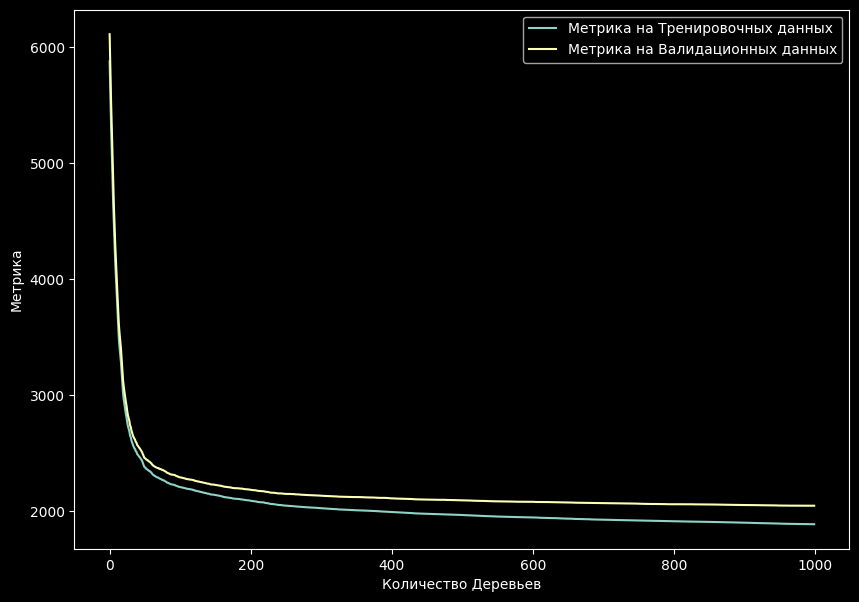

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results["learn"]["MAE"], label="Метрика на Тренировочных данных")
plt.plot(results["validation"]["MAE"], label="Метрика на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Метрика")
plt.legend();

# Контрольные вопросы